In [ ]:
t

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an autoregressive model and run it on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [ ]:
import os
assert os.environ['COLAB_TPU_ADDR']

In [ ]:
VERSION = "1.5"  #@param ["1.5" , "20200325", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5115  100  5115    0     0  71041      0 --:--:-- --:--:-- --:--:-- 71041
Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-1.5 ...
     |████████████████████████████████| 61kB 2.7MB/s 
Uninstalling torch-1.6.0+cu101:
  Found existing installation: google-api-python-client 1.7.12
    Uninstalling google-api-python-client-1.7.12:
      Successfully uninstalled google-api-python-client-1.7.12
Done updating TPU runtime
  Successfully uninstalled torch-1.6.0+cu101
Uninstalling torchvision-0.7.0+cu101:
  Successfully uninstalled torchvision-0.7.0+cu101
Copying gs://tpu-pytorch/wheels/torch-1.5-cp36-cp36m-linux_x86_64.whl...
- [1 files][ 79.0 MiB/ 79.0 MiB]                                                
Operation completed over 1 objects/79.0 MiB.                                     
Copying gs://tpu-pyto

In [ ]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 749, done.
remote: Total 749 (delta 0), reused 0 (delta 0), pack-reused 749
Receiving objects: 100% (749/749), 114.90 MiB | 10.58 MiB/s, done.
Resolving deltas: 100% (344/344), done.
Checking out files: 100% (129/129), done.
Processing ./deepul
  Created wheel for deepul: filename=deepul-0.1.0-cp36-none-any.whl size=16679 sha256=94c10e92ecde5e71e3c1842917e0f77f11cc19439df056739191c43fdaaf8ed2
  Stored in directory: /tmp/pip-ephem-wheel-cache-o1ezbpnq/wheels/39/1a/4b/a6f51db275abb2e5dae32540e06ed5011e792f162467bd3aa8
Successfully built deepul


In [ ]:
from deepul.hw1_helper import *

# Question 1: 1D Data

In this question, we will train simple generative models on discrete 1D data.

Execute the cell below to visualize our datasets

Dataset 1


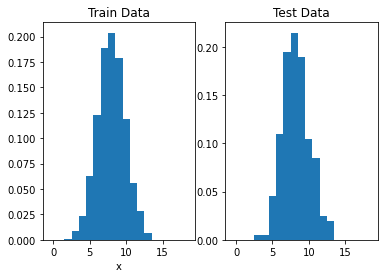

Dataset 2


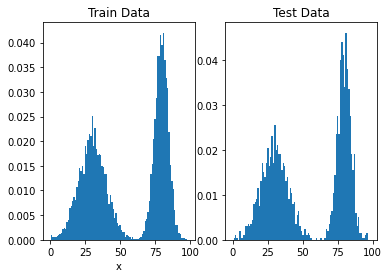

In [ ]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Fitting a Histogram

Let $\theta = (\theta_0, \dots, \theta_{d-1}) \in \mathbb{R}^d$ and define the model $p_\theta(x) = \frac{e^{\theta_x}}{\sum_{x'}e^{\theta_{x'}}}$

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Plot the model probabilities in a bar graph with $\{0,\dots,d-1\}$ on the x-axis and a real number in $[0,1]$ on the y-axis.




### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import torch.nn.functional as F

# import torch_xla
# import torch_xla.core.xla_model as xm

def train(model, data_loader, optimizer, device):
  # Returns list of train losses for each batch
  model.train()
  train_losses = []
  for x in data_loader:
    x = x.to(device)

    loss = model.loss(x)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

  return train_losses

def eval_model(model, data_loader, device):
  model.eval()

  test_loss = 0.0

  with torch.no_grad():
    for x in data_loader:
      x = x.to(device)

      loss = model.loss(x)

      test_loss = test_loss + loss*x.shape[0]
    test_loss = test_loss/len(data_loader.dataset)

  return test_loss.item()

    

def train_model(model, train_data_loader, test_data_loader, train_args):

  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")

  # device = xm.xla_device()
  print("Using device ... ", device)
  model = model.to(device)
  epochs = train_args.get('epochs', 10)
  lr = train_args.get('lr', 1e-3)

  optimizer = optim.Adam(params = model.parameters(), lr = lr)

  train_losses = []
  test_losses = [eval_model(model, test_data_loader, device)]

  for i in range(0, epochs):
    model.train()

    train_losses.extend(train(model = model, data_loader = train_data_loader, optimizer = optimizer,
                            device = device))
    test_loss_epoch = eval_model(model = model, data_loader = test_data_loader, device = device)
    test_losses.append(test_loss_epoch)

    print("Epoch: ",(i+1)," Test Loss: ",test_loss_epoch)

  return train_losses, test_losses

class Histogram(nn.Module):
  def __init__(self, d):
    super().__init__()
    self.d = d
    self.theta = nn.Parameter(data = torch.zeros(d), requires_grad = True)

  def loss(self, x):
    # size of x -> batch_size x 1
    # theta -> d -> 1 x d -> batch_size x d
    out = torch.unsqueeze(self.theta, 0).repeat(x.shape[0], 1)
    entropy_loss = nn.CrossEntropyLoss()
    return entropy_loss(out, x)

  def getDist(self):
    softmax = nn.Softmax()
    softmax_out = softmax(self.theta)
    return softmax_out.detach().cpu().numpy()

In [ ]:
def q1_a(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test,) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for random variable x
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d,) of model probabilities
  """
  
  """ YOUR CODE HERE """

  train_data_loader = data.DataLoader(dataset = train_data, batch_size = 64, shuffle = True)
  test_data_loader = data.DataLoader(dataset = test_data, batch_size = 64)

  model = Histogram(d)

  train_args = {'epochs':20, 'lr':1e-1}
  train_losses, test_losses = train_model(model = model, train_data_loader = train_data_loader, 
                                          test_data_loader = test_data_loader, train_args = train_args)
  
  return train_losses, test_losses, model.getDist()
  



### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



Using device ...  cpu
Epoch:  1  Test Loss:  2.1908180713653564
Epoch:  2  Test Loss:  2.09049654006958
Epoch:  3  Test Loss:  2.076695680618286
Epoch:  4  Test Loss:  2.0760836601257324
Epoch:  5  Test Loss:  2.069392681121826
Epoch:  6  Test Loss:  2.0604169368743896
Epoch:  7  Test Loss:  2.0602543354034424
Epoch:  8  Test Loss:  2.062542676925659
Epoch:  9  Test Loss:  2.0568959712982178
Epoch:  10  Test Loss:  2.0538997650146484
Epoch:  11  Test Loss:  2.0588057041168213
Epoch:  12  Test Loss:  2.0597987174987793
Epoch:  13  Test Loss:  2.0538077354431152
Epoch:  14  Test Loss:  2.0608630180358887
Epoch:  15  Test Loss:  2.0558629035949707
Epoch:  16  Test Loss:  2.0600266456604004
Epoch:  17  Test Loss:  2.051353693008423
Epoch:  18  Test Loss:  2.0556836128234863
Epoch:  19  Test Loss:  2.0534238815307617
Epoch:  20  Test Loss:  2.0544323921203613
Final Test Loss: 2.0544


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


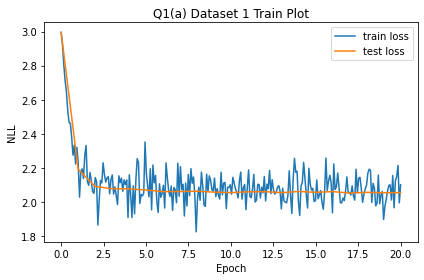

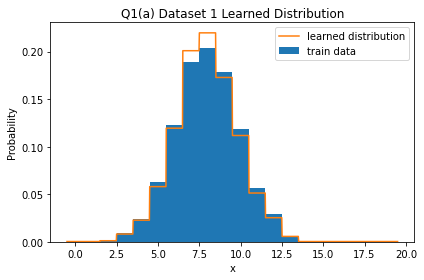

In [ ]:
q1_save_results(1, 'a', q1_a)

Using device ...  cpu
Epoch:  1  Test Loss:  4.052053928375244
Epoch:  2  Test Loss:  4.061552047729492
Epoch:  3  Test Loss:  4.0533528327941895
Epoch:  4  Test Loss:  4.057908058166504
Epoch:  5  Test Loss:  4.0440592765808105
Epoch:  6  Test Loss:  4.052647113800049
Epoch:  7  Test Loss:  4.053353786468506
Epoch:  8  Test Loss:  4.061624050140381
Epoch:  9  Test Loss:  4.058770656585693
Epoch:  10  Test Loss:  4.049199104309082
Epoch:  11  Test Loss:  4.053316116333008
Epoch:  12  Test Loss:  4.046177864074707
Epoch:  13  Test Loss:  4.05471658706665
Epoch:  14  Test Loss:  4.04567813873291
Epoch:  15  Test Loss:  4.051095962524414
Epoch:  16  Test Loss:  4.048351764678955
Epoch:  17  Test Loss:  4.053447723388672
Epoch:  18  Test Loss:  4.052060127258301
Epoch:  19  Test Loss:  4.061831951141357
Epoch:  20  Test Loss:  4.047984600067139
Final Test Loss: 4.0480


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


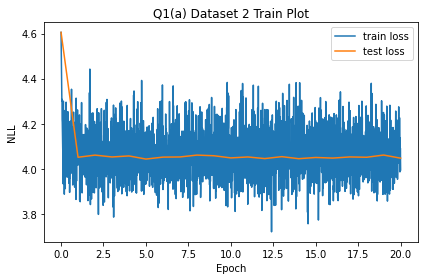

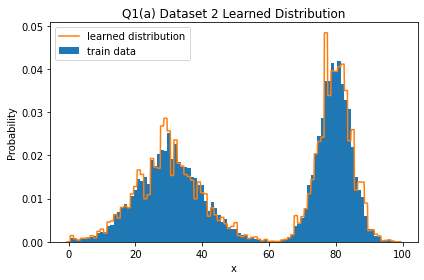

In [ ]:
q1_save_results(2, 'a', q1_a)

## Part (b) Fitting Discretized Mixture of Logistics

Let us model $p_\theta(x)$ as a **discretized** mixture of 4 logistics such that $p_\theta(x) = \sum_{i=1}^4 \pi_i[\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]$

For the edge case of when $x = 0$, we replace $x-0.5$ by $-\infty$, and for $x = d-1$, we replace $x+0.5$ by $\infty$.

You may find the [PixelCNN++](https://arxiv.org/abs/1701.05517) helpful for more information on discretized mixture of logistics.

**Provide the same set of corresponding deliverables as part (a)**

In [ ]:
class DML(nn.Module):

  def __init__(self, n_mix, d):
    super().__init__()
    self.n_mix = n_mix
    self.d = d

    # Initializing params
    self.means = nn.Parameter(data = torch.randn(n_mix), requires_grad = True) # (n_mix, )
    self.log_scales = nn.Parameter(data = torch.randn(n_mix), requires_grad = True) # (n_mix, )
    self.weights = nn.Parameter(data = torch.randn(n_mix), requires_grad = True) # (n_mix, )

  def forward(self, x):
    # shape = (batch_size, )
    x = x.float()
    x = torch.unsqueeze(input = x, dim = 1).repeat(1, self.n_mix) # batch_size, n_mix

    means = torch.unsqueeze(self.means, 0) # 1 x n_mix
    log_scales = torch.unsqueeze(self.log_scales, 0) # 1 x n_mix
    inv_scale = torch.exp(-log_scales)


    max_val = (x + 0.5 - means)*inv_scale
    min_val = (x - 0.5 - means)*inv_scale

    max_val_sigmoid = torch.sigmoid(max_val)
    min_val_sigmoid = torch.sigmoid(min_val)

    sigmoid_delta = max_val_sigmoid - min_val_sigmoid
    log_sigmoid_delta = torch.log(torch.clamp(sigmoid_delta, min=1e-12))

    # conditions
    # out = torch.where(x < 1e-3, zero_cond_log, 
    #                   torch.where(x > self.d - 1 - 1e-3, end_cond_log, log_sigmoid_delta))

    out = torch.where(x < 1e-3, torch.log(torch.clamp(max_val_sigmoid, min=1e-12)), 
                      torch.where(x > self.d - 1 - 1e-3, torch.log(torch.clamp(1 - min_val_sigmoid, min=1e-12)), log_sigmoid_delta))

    
    softmax = nn.Softmax(dim = 1)
    weights = torch.unsqueeze(self.weights, 0) # 1 x n_mix
    log_weights = torch.log(softmax(weights))

    log_out = out + log_weights

    
    return torch.logsumexp(input = log_out, dim = 1)

  def loss(self, x):
    return -torch.mean(self(x))
         
  def getDist(self):
    all_vals = torch.arange(start = 0, end = self.d, dtype=torch.float).cuda()
    
    
    
    with torch.no_grad():
      outs = torch.exp(self(all_vals))
    
    
    return outs.detach().cpu().numpy()


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q1_b(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test,) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for random variable x
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d,) of model probabilities
  """

  train_data_loader = data.DataLoader(dataset = train_data, batch_size = 64, shuffle = True)
  test_data_loader = data.DataLoader(dataset = test_data, batch_size = 64)

  model = DML(4, d)
  

  train_args = {'epochs':50, 'lr':1e-1}
  train_losses, test_losses = train_model(model = model, train_data_loader = train_data_loader, 
                                          test_data_loader = test_data_loader, train_args = train_args)
  
  return train_losses, test_losses, model.getDist()
  
  

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



Epoch:  1  Test Loss:  3.4103341102600098
Epoch:  2  Test Loss:  3.2606942653656006
Epoch:  3  Test Loss:  3.0367465019226074
Epoch:  4  Test Loss:  2.730553150177002
Epoch:  5  Test Loss:  2.339468240737915
Epoch:  6  Test Loss:  2.0643134117126465
Epoch:  7  Test Loss:  2.050753593444824
Epoch:  8  Test Loss:  2.058811664581299
Epoch:  9  Test Loss:  2.0668344497680664
Epoch:  10  Test Loss:  2.0598671436309814
Epoch:  11  Test Loss:  2.058223009109497
Epoch:  12  Test Loss:  2.059497594833374
Epoch:  13  Test Loss:  2.0568933486938477
Epoch:  14  Test Loss:  2.0609002113342285
Epoch:  15  Test Loss:  2.057436466217041
Epoch:  16  Test Loss:  2.0601115226745605
Epoch:  17  Test Loss:  2.0575685501098633
Epoch:  18  Test Loss:  2.0619940757751465
Epoch:  19  Test Loss:  2.0556836128234863
Epoch:  20  Test Loss:  2.0599870681762695
Epoch:  21  Test Loss:  2.0570738315582275
Epoch:  22  Test Loss:  2.0554606914520264
Epoch:  23  Test Loss:  2.0574216842651367
Epoch:  24  Test Loss:  2.0

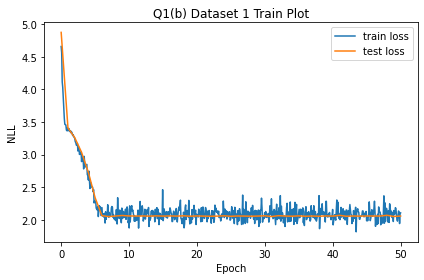

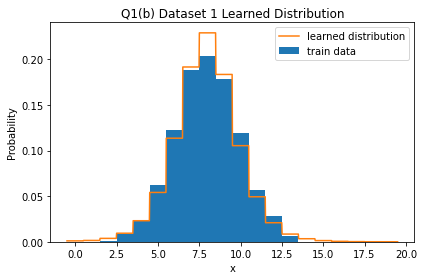

In [ ]:
q1_save_results(1, 'b', q1_b)

Epoch:  1  Test Loss:  5.5035319328308105
Epoch:  2  Test Loss:  5.427528381347656
Epoch:  3  Test Loss:  5.319430351257324
Epoch:  4  Test Loss:  5.179483413696289
Epoch:  5  Test Loss:  5.019638538360596
Epoch:  6  Test Loss:  4.87677526473999
Epoch:  7  Test Loss:  4.792813777923584
Epoch:  8  Test Loss:  4.759758472442627
Epoch:  9  Test Loss:  4.749607563018799
Epoch:  10  Test Loss:  4.746743679046631
Epoch:  11  Test Loss:  4.745933532714844
Epoch:  12  Test Loss:  4.745968341827393
Epoch:  13  Test Loss:  4.74591064453125
Epoch:  14  Test Loss:  4.745145320892334
Epoch:  15  Test Loss:  4.632180213928223
Epoch:  16  Test Loss:  4.494284629821777
Epoch:  17  Test Loss:  4.041175842285156
Epoch:  18  Test Loss:  4.051675796508789
Epoch:  19  Test Loss:  4.040421009063721
Epoch:  20  Test Loss:  4.042590618133545
Epoch:  21  Test Loss:  4.04154634475708
Epoch:  22  Test Loss:  4.045356273651123
Epoch:  23  Test Loss:  4.045955657958984
Epoch:  24  Test Loss:  4.046852111816406
Epo

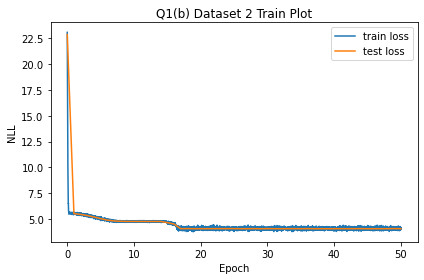

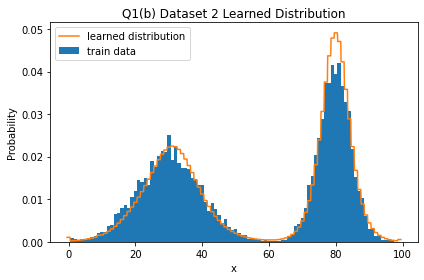

In [ ]:
q1_save_results(2, 'b', q1_b)

# Question 2: MADE

In this question, you will implement [MADE](https://arxiv.org/abs/1502.03509). In the first part, you will use MADE to model a simple 2D joint distribution, and in the second half, you will train MADE on image datasets.

## Part (a) Fitting 2D Data

First, you will work with bivariate data of the form $x = (x_0,x_1)$, where $x_0, x_1 \in \{0, \dots, d\}$. We can easily visualize a 2D dataset by plotting a 2D histogram. Run the cell below to visualize our datasets.

Dataset 1


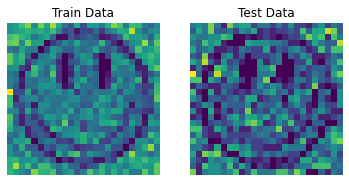

Dataset 2


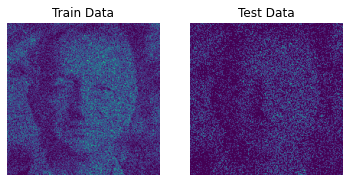

In [ ]:
visualize_q2a_data(dset_type=1)
visualize_q2a_data(dset_type=2)

Implement and train a MADE model through maximum likelihood to represent $p(x_0, x_1)$ on the given datasets, with any autoregressive ordering of your choosing. 

A few notes:
* You do not need to do training with multiple masks
* You made find it useful to one-hot encode your inputs. 

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Visualize the learned 2D distribution by plotting a 2D heatmap


In [ ]:
def to_one_hot(labels, d):
  one_hot = torch.FloatTensor(labels.shape[0], d)
  one_hot.zero_()
  one_hot.scatter_(1, labels.unsqueeze(1), 1)
  return one_hot

x2 = to_one_hot(y.long().reshape(-1), 10).view(y.shape[0], -1)
print(x2.shape)

torch.Size([4, 20])


In [ ]:
x = torch.Tensor([[[0, 1], [1, 0]]])
y = torch.Tensor([[1,0]]).long()
loss = nn.CrossEntropyLoss()
print(loss(x,y))
print((1 - np.log(1 + np.exp(1))))

tensor(0.3133)
-0.3132616875182228


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def to_one_hot(labels, d):
  one_hot = torch.FloatTensor(labels.shape[0], d).cuda()
  one_hot.zero_()
  one_hot.scatter_(1, labels.unsqueeze(1), 1)
  return one_hot


class MaskedLayer(nn.Module):
  def __init__(self, in_features, out_features, d, bias=True):
    super(MaskedLayer, self).__init__()

    self.in_features = in_features
    self.out_features = out_features
    self.d = d

    self.weights = nn.Linear(in_features = in_features, out_features = out_features, bias = bias)
    
    self.register_buffer(
            "mask", torch.ones_like(self.weights.weight).type(torch.uint8)
        )

    # Assign number between 1 - d-1 to each neuron
    c = 0
    while(c <= 10):
      c += 1
      self.mask_vals = torch.randint(low = 1, high = self.d, size = (out_features, ))
      all_vals = set(np.arange(1, self.d))
      if len(all_vals - set(self.mask_vals.numpy())) == 0:
        break


  def set_mask(self, prev_layer_mask):
    p_t = prev_layer_mask.unsqueeze(0).repeat((self.mask_vals.shape[0], 1))
    c_t = self.mask_vals.unsqueeze(0).T.repeat((1, prev_layer_mask.shape[0]))
    self.mask = (c_t >= p_t).int()


  def forward(self, x):  
    out = F.linear(input = x, weight = self.mask*self.weights.weight, bias = self.weights.bias)
    return out



class MADE(nn.Module):
  def __init__(self, input_shape, d, hidden_sizes, one_hot_encode = False):
    super(MADE, self).__init__()
    self.input_shape = input_shape
    self.inp_num = np.prod(input_shape)
    self.nin = np.prod(input_shape)
    self.d = d
    self.hidden_sizes = hidden_sizes
    self.one_hot_encode = one_hot_encode
    self.nout = self.nin*self.d

    if one_hot_encode:
      self.nin = self.nin*self.d
      inp_layer_mask = torch.arange(start = 1, end = self.inp_num + 1)
      inp_layer_mask[-1] = 1e9
      inp_layer_mask = inp_layer_mask.unsqueeze(0).T.repeat((1, self.d)).view(self.nin) # nin x d  
      

    else:
      inp_layer_mask = torch.arange(start = 1, end = self.nin + 1)
      inp_layer_mask[-1] = 1e9

    out_layer_mask = torch.arange(start = 0, end = self.inp_num)
    out_layer_mask = out_layer_mask.unsqueeze(0).T.repeat((1, self.d)).view(self.inp_num*d) # nin x d

    self.nn_list = []

    # hidden sizes excludes output layer

    prev_layer_mask = inp_layer_mask
    in_feats = self.nin
    for i in range(0, len(hidden_sizes)):
      
      layer = MaskedLayer(in_feats, hidden_sizes[i], self.inp_num)
      layer.set_mask(prev_layer_mask)
      
      self.nn_list.extend([layer, nn.ELU()])

      prev_layer_mask = layer.mask_vals
      in_feats = hidden_sizes[i]
    
    output_layer = MaskedLayer(hidden_sizes[-1], self.nout, self.inp_num)
    output_layer.mask_vals = out_layer_mask
    output_layer.set_mask(prev_layer_mask)
    self.nn_list.extend([output_layer])

    self.net = nn.Sequential(*self.nn_list)

  def forward(self, x):
    # x -> batch_size x input_shape
    # print("Before: ",x.shape)
    batch_size = x.shape[0]
    if self.one_hot_encode:
      # x = torch.sum(F.one_hot(x.to(torch.int64), self.d), dim = 1)
      x = F.one_hot(x.to(torch.int64), self.d).view(batch_size, self.nin).float()
      # x = x.long().reshape(-1)
      # x = to_one_hot(x, self.d)
      # x = x.view(batch_size, -1)

    else:
      x = x.float()
      x = x.view(batch_size, self.nin)

    out = self.net(x)
    # print("Output shape: ", out.shape)
    out = out.view((batch_size, np.prod(self.input_shape), self.d))
    # softmax = nn.Softmax(dim = 1)
    # out = softmax(out)
    out = out.permute(0, 2, 1).contiguous().view(batch_size, self.d, *self.input_shape)
    # print(out.shape)
    return out

  def loss(self, x):
    return F.cross_entropy(self(x), x.long())

  def sample(self, n):
    x = torch.zeros(size=(n, self.nin)).float().cuda()
    out_vals = []
    with torch.no_grad():
      for i in range(0, self.nin):
        out = self(x) # n x 2 x input_shape
        softmax = nn.Softmax(dim = 1)
        out = softmax(out)
        vals = torch.multinomial(out[:, :, i], 1).unsqueeze(-1)
        x[:, i] = vals

  # def sample(self, n):
  #   samples = torch.zeros(n, self.nin).cuda()
  #   with torch.no_grad():
  #     for i in range(self.nin):
  #       logits = self(samples).view(n, self.d, self.nin)[:, :, i]
  #       probs = F.softmax(logits, dim=1)
  #       samples[:, i] = torch.multinomial(probs, 1).squeeze(-1)
  #     samples = samples.view(n, *self.input_shape)
  #   return samples.cpu().numpy()


  def get_dist(self):
    # x = np.mgrid[0:self.d, 0:self.d].reshape(2, self.d**2).T
    # x = torch.LongTensor(x).cuda()
    # probs = self(x) 
    # print(probs)
    x = np.mgrid[0:self.d, 0:self.d].reshape(2, self.d ** 2).T
    x = torch.LongTensor(x).cuda()
    probs = F.log_softmax(self(x), dim = 1)
    distribution = torch.gather(probs, 1, x.unsqueeze(1)).squeeze(1)
    distribution = distribution.sum(dim=1)
    return distribution.exp().view(self.d, self.d).detach().cpu().numpy()





        
        



In [ ]:
def q2_a(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train, 2) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test, 2) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for each random variable x1 and x2
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d, d) of probabilities (the learned joint distribution)
  """
  
  
  train_data_loader = data.DataLoader(dataset = train_data, batch_size = 128, shuffle = True)
  test_data_loader = data.DataLoader(dataset = test_data, batch_size = 128)

  model = MADE((2,), d, [100, 100], one_hot_encode=True)
  
  train_args = {'epochs':20, 'lr':2e-3}
  train_losses, test_losses = train_model(model = model, train_data_loader = train_data_loader, 
                                          test_data_loader = test_data_loader, train_args = train_args)
  dist = model.get_dist()
  # print(dist)
  return train_losses, test_losses, dist



### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results



Epoch:  1  Test Loss:  3.206214427947998
Epoch:  2  Test Loss:  3.1920230388641357
Epoch:  3  Test Loss:  3.1858291625976562
Epoch:  4  Test Loss:  3.186519145965576
Epoch:  5  Test Loss:  3.185192346572876
Epoch:  6  Test Loss:  3.185671806335449
Epoch:  7  Test Loss:  3.185229539871216
Epoch:  8  Test Loss:  3.1840596199035645
Epoch:  9  Test Loss:  3.1853506565093994
Epoch:  10  Test Loss:  3.18660569190979
Epoch:  11  Test Loss:  3.1850244998931885
Epoch:  12  Test Loss:  3.1863269805908203
Epoch:  13  Test Loss:  3.187880754470825
Epoch:  14  Test Loss:  3.185196876525879
Epoch:  15  Test Loss:  3.1873679161071777
Epoch:  16  Test Loss:  3.186309576034546
Epoch:  17  Test Loss:  3.1878883838653564
Epoch:  18  Test Loss:  3.1865134239196777
Epoch:  19  Test Loss:  3.1860809326171875
Epoch:  20  Test Loss:  3.185469150543213
Final Test Loss: 3.1855


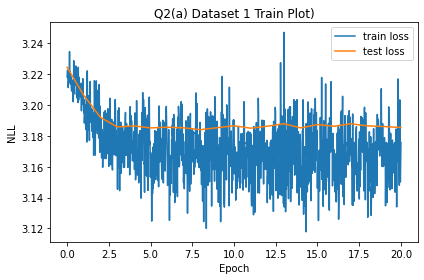

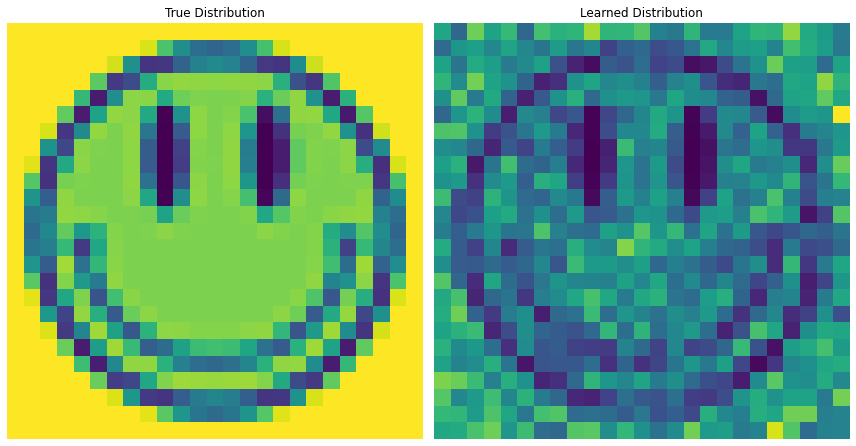

In [ ]:
q2_save_results(1, 'a', q2_a)

Epoch:  1  Test Loss:  5.271042823791504
Epoch:  2  Test Loss:  5.271704196929932
Epoch:  3  Test Loss:  5.278689861297607
Epoch:  4  Test Loss:  5.28602933883667
Epoch:  5  Test Loss:  5.290843486785889
Epoch:  6  Test Loss:  5.295955181121826
Epoch:  7  Test Loss:  5.299497604370117
Epoch:  8  Test Loss:  5.302459716796875
Epoch:  9  Test Loss:  5.305763244628906
Epoch:  10  Test Loss:  5.308884143829346
Epoch:  11  Test Loss:  5.31170654296875
Epoch:  12  Test Loss:  5.312254905700684
Epoch:  13  Test Loss:  5.313840866088867
Epoch:  14  Test Loss:  5.315633296966553
Epoch:  15  Test Loss:  5.316870212554932
Epoch:  16  Test Loss:  5.318852424621582
Epoch:  17  Test Loss:  5.31995964050293
Epoch:  18  Test Loss:  5.322017669677734
Epoch:  19  Test Loss:  5.323658466339111
Epoch:  20  Test Loss:  5.324706554412842
Final Test Loss: 5.3247


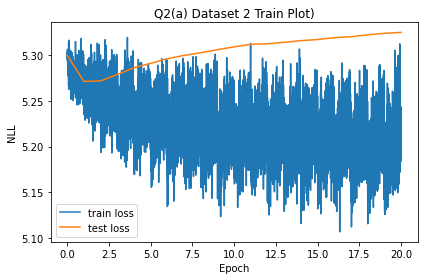

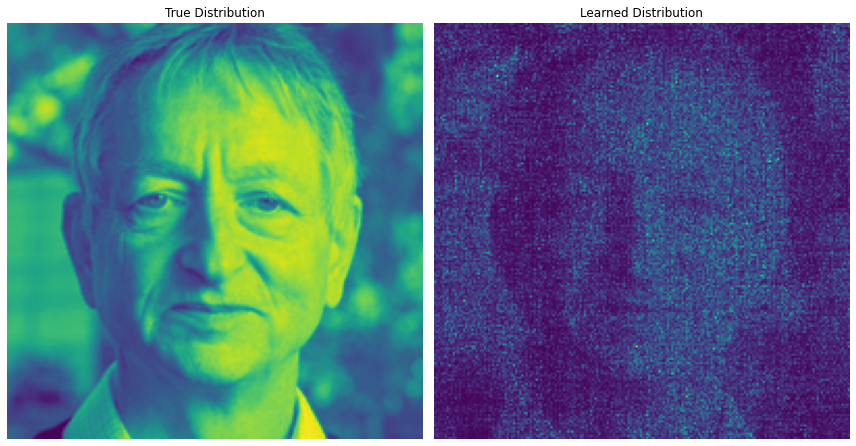

In [ ]:
q2_save_results(2, 'a', q2_a)

## Part (b) Shapes and MNIST
Now, we will work with a higher dimensional datasets, namely a shape dataset and MNIST. Run the cell below to visualize the two datasets

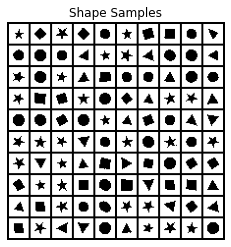

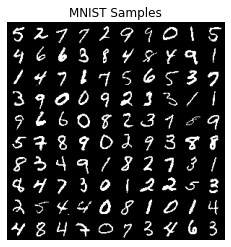

In [ ]:
visualize_q2b_data(1)
visualize_q2b_data(2)

Implement and train a MADE model on the given binary image datasets. Given some binary image of height $H$ and width $W$, we can represent image $x\in \{0, 1\}^{H\times W}$ as a flattened binary vector $x\in \{0, 1\}^{HW}$ to input into MADE to model $p_\theta(x) = \prod_{i=1}^{HW} p_\theta(x_i|x_{<i})$. Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q2_b(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: An (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  image_shape: (H, W), height and width of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
  """
  train_data_size, H_train, W_train = train_data.shape[0], train_data.shape[1], train_data.shape[2]
  test_data_size, H_test, W_test = test_data.shape[0], test_data.shape[1], test_data.shape[2]

  train_data = train_data.reshape((train_data_size, H_train*W_train))
  test_data = test_data.reshape((test_data_size, H_test*W_test))

  train_data_loader = data.DataLoader(dataset = train_data, batch_size = 128, shuffle = True)
  test_data_loader = data.DataLoader(dataset = test_data, batch_size = 128)

  model = MADE((np.prod(image_shape), ), 2, [512, 512], one_hot_encode=False)
  
  train_args = {'epochs':20, 'lr':1e-3}
  train_losses, test_losses = train_model(model = model, train_data_loader = train_data_loader, 
                                          test_data_loader = test_data_loader, train_args = train_args)
  # dist = model.get_dist()
  # print(dist)
  samples = model.sample(100)
  print(samples.shape)
  samples = samples.reshape(100, image_shape[0], image_shape[1], 1)
  return train_losses, test_losses, samples

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



Epoch:  1  Test Loss:  0.15712234377861023
Epoch:  2  Test Loss:  0.12721875309944153
Epoch:  3  Test Loss:  0.10822739452123642
Epoch:  4  Test Loss:  0.09551717340946198
Epoch:  5  Test Loss:  0.08772780746221542
Epoch:  6  Test Loss:  0.08177968114614487
Epoch:  7  Test Loss:  0.07783502340316772
Epoch:  8  Test Loss:  0.07372495532035828
Epoch:  9  Test Loss:  0.07016834616661072
Epoch:  10  Test Loss:  0.0676933228969574
Epoch:  11  Test Loss:  0.06498297303915024
Epoch:  12  Test Loss:  0.06300504505634308
Epoch:  13  Test Loss:  0.061379097402095795
Epoch:  14  Test Loss:  0.059294022619724274
Epoch:  15  Test Loss:  0.057794440537691116
Epoch:  16  Test Loss:  0.05629176273941994
Epoch:  17  Test Loss:  0.05491120368242264
Epoch:  18  Test Loss:  0.054230011999607086
Epoch:  19  Test Loss:  0.052971791476011276
Epoch:  20  Test Loss:  0.052584655582904816
(100, 400)
Final Test Loss: 0.0526


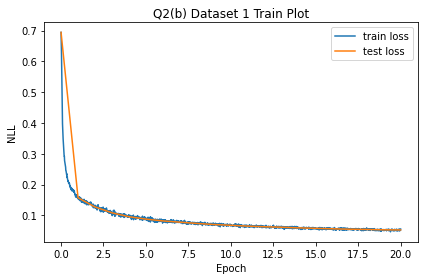

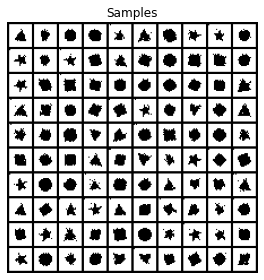

In [ ]:
q2_save_results(1, 'b', q2_b)

Epoch:  1  Test Loss:  0.17945332825183868
Epoch:  2  Test Loss:  0.14221100509166718
Epoch:  3  Test Loss:  0.12942980229854584
Epoch:  4  Test Loss:  0.12298186868429184
Epoch:  5  Test Loss:  0.11882045865058899
Epoch:  6  Test Loss:  0.11607681959867477
Epoch:  7  Test Loss:  0.11404719948768616
Epoch:  8  Test Loss:  0.11262191832065582
Epoch:  9  Test Loss:  0.11114653199911118
Epoch:  10  Test Loss:  0.11018263548612595
Epoch:  11  Test Loss:  0.10963501036167145
Epoch:  12  Test Loss:  0.10856946557760239
Epoch:  13  Test Loss:  0.10821554809808731
Epoch:  14  Test Loss:  0.10764198005199432
Epoch:  15  Test Loss:  0.10718227177858353
Epoch:  16  Test Loss:  0.10677194595336914
Epoch:  17  Test Loss:  0.10633276402950287
Epoch:  18  Test Loss:  0.10641131550073624
Epoch:  19  Test Loss:  0.10602822154760361
Epoch:  20  Test Loss:  0.10580335557460785
(100, 784)
Final Test Loss: 0.1058


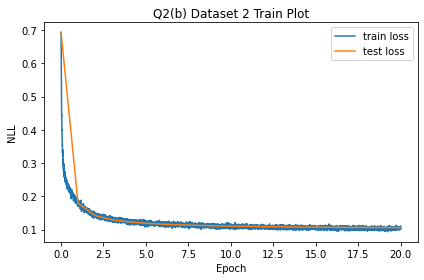

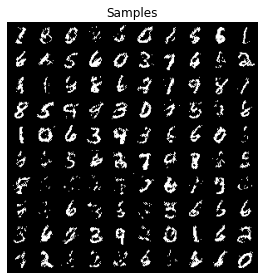

In [ ]:
q2_save_results(2, 'b', q2_b)

# Question 3 PixelCNNs

Now, you will train more powerful PixleCNN models on the shapes dataset and MNIST. In addition, we will extend to modelling colored datasets with and without channel conditioning.



## Part (a) PixelCNN on Shapes and MNIST
In this part, implement a simple PixelCNN architecture to model binary MNIST and shapes images (same as Q2(b), but with a PixelCNN).

We recommend the following network design:
* A $7 \times 7$ masked type A convolution
* $5$ $7 \times 7$ masked type B convolutions
* $2$ $1 \times 1$ masked type B convolutions
* Appropriate ReLU nonlinearities in-between
* 64 convolutional filters

And the following hyperparameters:
* Batch size 128
* Learning rate $10^{-3}$
* 10 epochs
* Adam Optimizer (this applies to all PixelCNN models trained in future parts)

Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine). It may also help to scale your input to $[-1, 1]$ before running it through the network. 

Training on the shapes dataset should be quick, and MNIST should take around 10 minutes

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



In [ ]:
class Binary_MaskedConvLayer(nn.Conv2d):
  def __init__(self, mask_type, *args, **kwargs):
    super(Binary_MaskedConvLayer, self).__init__(*args, **kwargs)

    assert mask_type == 'A' or mask_type == 'B'
    self.mask_type = mask_type
    self.register_buffer('mask', torch.zeros_like(self.weight))
    self.create_mask()
  
  def create_mask(self):
    k = self.kernel_size[0]

    # out_channels x in_channels x kernel_size x kernel_size
    self.mask[:, :, :k//2, :] = 1
    self.mask[:, :, k//2, :k//2] = 1

    if self.mask_type == 'B':
      self.mask[:, :, k//2, k//2] = 1


  def forward(self, x):
    out = F.conv2d(input = x, weight = self.weight * self.mask, bias = self.bias, stride = self.stride, 
                   padding = self.padding, dilation = self.dilation, groups = self.groups)
    return out

  
class Binary_PixelCNN(nn.Module):
  def __init__(self, n_filters = 64):
    super(Binary_PixelCNN, self).__init__()

    self.n_filters = n_filters
    models = []
    models.append(Binary_MaskedConvLayer(mask_type = 'A', in_channels = 1, out_channels = n_filters, kernel_size = 7, padding = 7//2))
    models.append(nn.ReLU())
    

    # 5 7 x 7 B conv layers
    for _ in range(0, 5):
      models.append(Binary_MaskedConvLayer(mask_type = 'B', in_channels = n_filters, out_channels = n_filters, kernel_size = 7, padding = 7//2))
      models.append(nn.ReLU())
    
    # 2 1 x 1 B conv layers
    
    models.append(Binary_MaskedConvLayer(mask_type = 'B', in_channels = n_filters, out_channels = n_filters, kernel_size = 1, padding = 1//2))
    models.append(nn.ReLU())

    # output = 2 x inp_shape
    models.append(Binary_MaskedConvLayer(mask_type = 'B', in_channels = n_filters, out_channels = 2, kernel_size = 1, padding = 1//2))
    
    self.net = nn.Sequential(*models)

  def forward(self, x):
    # x = x.float()
    x = (x.float() - 0.5) / 0.5
    batch_size = x.shape[0]

    inp_shape = (x.shape[1], x.shape[2], x.shape[3]) # 1 x W x H

    out = self.net(x)

    # out shape = 2 x inp_shape
    return out.contiguous().view(batch_size, 2, *inp_shape)

  def loss(self, x):
    out = self(x)
    return F.cross_entropy(out, x.long())
    

  def sample(self, N, inp_shape):
    sample_imgs = torch.zeros(N, *inp_shape).cuda()
    H, W = inp_shape[1], inp_shape[2]

    with torch.no_grad():
      for i in range(0, H):
        for j in range(0, W):
          out = self(sample_imgs)[:, :, 0, i, j] # shape -> N x 2 x 1 x 1 x 1

          softmax = nn.Softmax(dim = 1)
          probs = softmax(out) # shape -> N x 2 x 1 x 1 x 1
          sampled = torch.multinomial(input = probs, num_samples = 1)

          sample_imgs[:, 0, i, j] = sampled.squeeze(-1)

      return sample_imgs.permute(0, 2, 3, 1).cpu().numpy()





### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q3_a(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  image_shape: (H, W), height and width of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
  """
  
  """ YOUR CODE HERE """
  train_data = np.transpose(train_data, (0, 3, 1, 2))
  test_data = np.transpose(test_data, (0, 3, 1, 2))

  train_data_loader = data.DataLoader(dataset = train_data, batch_size = 128, shuffle = True)
  test_data_loader = data.DataLoader(dataset = test_data, batch_size = 128)

  binary_pixel_cnn = Binary_PixelCNN()

  train_args = {'epochs':20, 'lr':1e-3}
  train_losses, test_losses = train_model(model = binary_pixel_cnn, train_data_loader = train_data_loader, 
                                          test_data_loader = test_data_loader, train_args = train_args)


  samples = binary_pixel_cnn.sample(100, (1, *image_shape))

  return train_losses, test_losses, samples


### Results

Once you've implemented `q3_a`, execute the cells below to visualize and save your results



In [ ]:
q3a_save_results(1, q3_a)

Using device ...  cuda
Epoch:  1  Test Loss:  0.15301205217838287
Epoch:  2  Test Loss:  0.13010337948799133
Epoch:  3  Test Loss:  0.10644330829381943
Epoch:  4  Test Loss:  0.08826505392789841


Epoch:  1  Test Loss:  0.08783413469791412
Epoch:  2  Test Loss:  0.0837564691901207
Epoch:  3  Test Loss:  0.08180950582027435
Epoch:  4  Test Loss:  0.08027416467666626
Epoch:  5  Test Loss:  0.08026085793972015
Epoch:  6  Test Loss:  0.07952175289392471
Epoch:  7  Test Loss:  0.07916292548179626
Epoch:  8  Test Loss:  0.07894258946180344
Epoch:  9  Test Loss:  0.07834312319755554
Epoch:  10  Test Loss:  0.0772814154624939
Final Test Loss: 0.0773


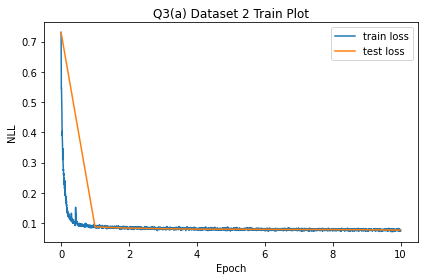

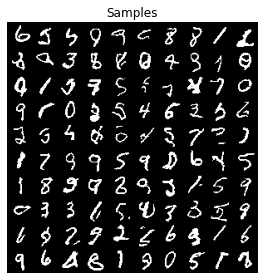

In [ ]:
q3a_save_results(2, q3_a)

## Part (b) PixelCNN on Colored Shapes and MNIST: Independent Color Channels

For the next two parts, we'll work with color images (shapes and MNIST). Run the cell below to visualize the dataset.

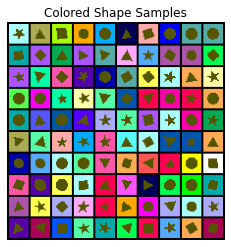

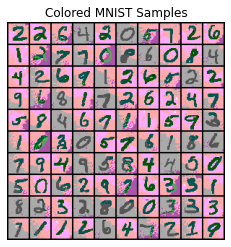

In [ ]:
visualize_q3b_data(1)
visualize_q3b_data(2)

Now, implement a PixelCNN to support RGB color channels (or augment your existing implementation). **First, implement a PixelCNN that assumes color channels as independent.** More formally, we model the following parameterized distribution:

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_{<i})$$

Here are some tips that you may find useful for designing and training these models:
* You will need a 4-way softmax for every prediction, as opposed to a 256-way softmax in the PixelCNN paper, since the dataset is quantized to two bits per color channel
* You can set number of filters for each convolutions to 120. You can use the ReLU nonlinearity throughout.
* Use a stack of 8 residual block architecture from [Figure 5](https://arxiv.org/abs/1601.06759) but with 7 x 7 masked convolutions in the middle instead of 3 x 3 masked convolutions
* Consider using [layer normalization](https://arxiv.org/abs/1607.06450) to improve performance. However, be careful to maintain the autoregressive property.
* With a learning rate of $10^{-3}$ and a batch size of 128, it should take a few minutes to run on the shapes dataset, and about 50-60 minutes on MNIST.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



In [ ]:
class Color_MaskedConvLayer(nn.Conv2d):
  def __init__(self, mask_type, *args, **kwargs):
    super(Color_MaskedConvLayer, self).__init__(*args, **kwargs)

    assert mask_type == 'A' or mask_type == 'B'
    self.mask_type = mask_type
    self.register_buffer('mask', torch.zeros_like(self.weight))
    self.create_mask()
  
  def create_mask(self):
    k = self.kernel_size[0]

    # out_channels x in_channels x kernel_size x kernel_size
    self.mask[:, :, :k//2, :] = 1
    self.mask[:, :, k//2, :k//2] = 1

    if self.mask_type == 'B':
      self.mask[:, :, k//2, k//2] = 1


  def forward(self, x):
    out = F.conv2d(input = x, weight = self.weight * self.mask, bias = self.bias, stride = self.stride, 
                   padding = self.padding, dilation = self.dilation, groups = self.groups)
    return out


class ResBlock(nn.Module):
  def __init__(self, in_channels):
    super(ResBlock, self).__init__()
    model_list = []
    self.in_channels = in_channels
    model_list = [
                  nn.ReLU()
                  ,Color_MaskedConvLayer('B', in_channels = in_channels, out_channels = in_channels//2, kernel_size = 1, padding = 1//2)
                  ,nn.ReLU()
                  ,Color_MaskedConvLayer('B', in_channels = in_channels//2, out_channels = in_channels//2, kernel_size = 7, padding = 7//2)
                  ,nn.ReLU()
                  ,Color_MaskedConvLayer('B', in_channels = in_channels//2, out_channels = in_channels, kernel_size = 1, padding = 1//2)
                ]
    self.resblock = nn.Sequential(*model_list)

  def forward(self, x):
    out = self.resblock(x)
    return out + x



class Color_PixelCNN(nn.Module):
  def __init__(self, n_colors, n_filters = 120, n_layers = 8):
    super(Color_PixelCNN, self).__init__()

    self.n_colors = n_colors
    self.n_filters = n_filters
    self.n_layers = n_layers
    models = []
    models.append(Color_MaskedConvLayer(mask_type = 'A', in_channels = 3, out_channels = n_filters, kernel_size = 7, padding = 7//2))
    
    for _ in range(0, n_layers):
      models.append(nn.BatchNorm2d(num_features = n_filters))
      models.append(nn.ReLU())
      models.append(ResBlock(n_filters))
    
    models.append(nn.BatchNorm2d(num_features = n_filters))
    models.append(nn.ReLU())
    models.append(Color_MaskedConvLayer(mask_type = 'B', in_channels = n_filters, out_channels = 3*n_colors, kernel_size = 7, padding = 7//2))
    
    self.net = nn.Sequential(*models)

  def forward(self, x):
    # x = x.float()
    x = (x.float() - 0.5) / 0.5
    batch_size = x.shape[0]

    inp_shape = (x.shape[1], x.shape[2], x.shape[3]) # 3 x W x H

    out = self.net(x)

    # out shape = n_colors x inp_shape
    return out.contiguous().view(batch_size, self.n_colors, *inp_shape)

  def loss(self, x):
    out = self(x)
    return F.cross_entropy(out, x.long())
    

  def sample(self, N, inp_shape):
    sample_imgs = torch.zeros(N, *inp_shape).cuda()
    C, H, W = inp_shape[0], inp_shape[1], inp_shape[2]

    with torch.no_grad():
      for i in range(0, H):
        for j in range(0, W):
          for k in range(0, 3):
            out = self(sample_imgs)[:, :, k, i, j] # shape -> N x 4 x 1 x 1 x 1

            softmax = nn.Softmax(dim = 1)
            probs = softmax(out) # shape -> N x 4 x 1 x 1 x 1
            sampled = torch.multinomial(input = probs, num_samples = 1)

            sample_imgs[:, k, i, j] = sampled.squeeze(-1)

      return sample_imgs.permute(0, 2, 3, 1).cpu().numpy()





### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q3_b(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
  """
  
  H, W, C = image_shape
  train_data = np.transpose(train_data, (0, 3, 1, 2))
  test_data = np.transpose(test_data, (0, 3, 1, 2))

  train_data_loader = data.DataLoader(dataset = train_data, batch_size = 128, shuffle = True)
  test_data_loader = data.DataLoader(dataset = test_data, batch_size = 128)

  color_pixel_cnn = Color_PixelCNN(n_colors = 4)

  train_args = {'epochs':15, 'lr':1e-3}
  train_losses, test_losses = train_model(model = color_pixel_cnn, train_data_loader = train_data_loader, 
                                          test_data_loader = test_data_loader, train_args = train_args)


  samples = color_pixel_cnn.sample(100, (C, H, W))

  return train_losses, test_losses, samples

### Results

Once you've implemented `q3_b`, execute the cells below to visualize and save your results



Epoch:  1  Test Loss:  0.10867444425821304
Epoch:  2  Test Loss:  0.08314920961856842
Epoch:  3  Test Loss:  0.07087714225053787
Epoch:  4  Test Loss:  0.061545468866825104
Epoch:  5  Test Loss:  0.05704948306083679
Epoch:  6  Test Loss:  0.051911965012550354
Epoch:  7  Test Loss:  0.04807227477431297
Epoch:  8  Test Loss:  0.0472131073474884
Epoch:  9  Test Loss:  0.05163273960351944
Epoch:  10  Test Loss:  0.0456058569252491
Epoch:  11  Test Loss:  0.04271005094051361
Epoch:  12  Test Loss:  0.041741497814655304
Epoch:  13  Test Loss:  0.044280316680669785
Epoch:  14  Test Loss:  0.041434627026319504
Epoch:  15  Test Loss:  0.04046804457902908
Final Test Loss: 0.0405


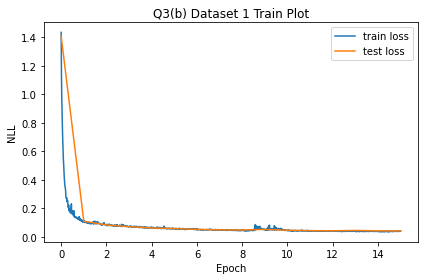

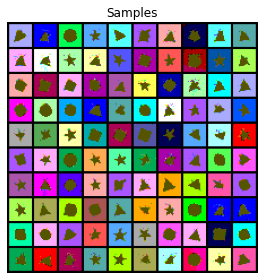

In [ ]:
q3bc_save_results(1, 'b', q3_b)

Epoch:  1  Test Loss:  0.1293129324913025
Epoch:  2  Test Loss:  0.10074136406183243
Epoch:  3  Test Loss:  0.09049494564533234
Epoch:  4  Test Loss:  0.08711466193199158
Epoch:  5  Test Loss:  0.08503182232379913
Epoch:  6  Test Loss:  0.08322285860776901
Epoch:  7  Test Loss:  0.08524540811777115
Epoch:  8  Test Loss:  0.08268903195858002
Epoch:  9  Test Loss:  0.08147141337394714
Epoch:  10  Test Loss:  0.08138713985681534
Epoch:  11  Test Loss:  0.08023130148649216
Epoch:  12  Test Loss:  0.08020998537540436
Epoch:  13  Test Loss:  0.0800861045718193
Epoch:  14  Test Loss:  0.081486776471138
Epoch:  15  Test Loss:  0.08344743400812149
Final Test Loss: 0.0834


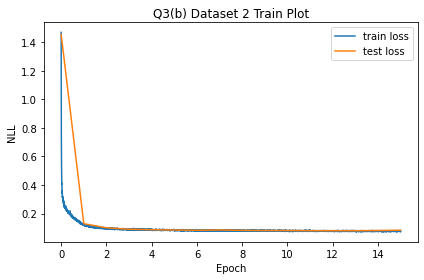

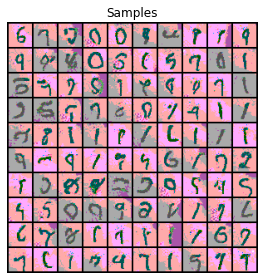

In [ ]:
q3bc_save_results(2, 'b', q3_b)

## Part (c) PixelCNN on Colored Shapes and MNIST: Autoregressive Color Channels

Now, implement a PixelCNN that models **dependent** color channels. Formally, we model the parameterized distribution

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_i^{<c}, x_{<i})$$

To do so, change your masking scheme for the center pixel. Split the filters into 3 groups, only allowing each group to see the groups before (or including the current group, for type B masks) to maintain the autoregressive property.

Training times and hyperparameter settings should be the same as part (b).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
class Color_MaskedConvLayer(nn.Conv2d):
  def __init__(self, mask_type, color_cond = 1, *args, **kwargs):
    super(Color_MaskedConvLayer, self).__init__(*args, **kwargs)

    assert mask_type == 'A' or mask_type == 'B'
    self.mask_type = mask_type
    self.register_buffer('mask', torch.zeros_like(self.weight))
    self.color_cond = color_cond
    self.create_mask()
  
  def create_mask(self):
    k = self.kernel_size[0]

    # out_channels x in_channels x kernel_size x kernel_size
    self.mask[:, :, :k//2, :] = 1
    self.mask[:, :, k//2, :k//2] = 1

    if self.color_cond:
      assert self.out_channels % 3 == 0 and self.in_channels % 3 == 0
      one_third_out = int(self.out_channels/3)
      one_third_in = int(self.in_channels/3)
      if self.mask_type == 'A':
        # self.mask[:one_third_out, ]
        self.mask[one_third_out:2*one_third_out, :one_third_in, k//2, k//2] = 1
        self.mask[2*one_third_out: , :2*one_third_in, k//2, k//2] = 1
      else:
        self.mask[:one_third_out, :one_third_in, k//2, k//2] = 1
        self.mask[one_third_out:2*one_third_out, :2*one_third_in, k//2, k//2] = 1
        self.mask[2*one_third_out:, :, k//2, k//2] = 1

    elif self.mask_type == 'B':
      self.mask[:, :, k//2, k//2] = 1


  def forward(self, x):
    out = F.conv2d(input = x, weight = self.weight * self.mask, bias = self.bias, stride = self.stride, 
                   padding = self.padding, dilation = self.dilation, groups = self.groups)
    return out


class ResBlock(nn.Module):
  def __init__(self, in_channels):
    super(ResBlock, self).__init__()
    model_list = []
    self.in_channels = in_channels
    model_list = [
                  nn.ReLU()
                  ,Color_MaskedConvLayer('B', in_channels = in_channels, out_channels = in_channels//2, kernel_size = 1, padding = 1//2)
                  ,nn.ReLU()
                  ,Color_MaskedConvLayer('B', in_channels = in_channels//2, out_channels = in_channels//2, kernel_size = 7, padding = 7//2)
                  ,nn.ReLU()
                  ,Color_MaskedConvLayer('B', in_channels = in_channels//2, out_channels = in_channels, kernel_size = 1, padding = 1//2)
                ]
    self.resblock = nn.Sequential(*model_list)

  def forward(self, x):
    out = self.resblock(x)
    return out + x



class Color_PixelCNN(nn.Module):
  def __init__(self, n_colors, n_filters = 120, n_layers = 8):
    super(Color_PixelCNN, self).__init__()

    self.n_colors = n_colors
    self.n_filters = n_filters
    self.n_layers = n_layers
    models = []
    models.append(Color_MaskedConvLayer(mask_type = 'A', in_channels = 3, out_channels = n_filters, kernel_size = 7, padding = 7//2))
    
    for _ in range(0, n_layers):
      models.append(nn.BatchNorm2d(num_features = n_filters))
      models.append(nn.ReLU())
      models.append(ResBlock(n_filters))
    
    models.append(nn.BatchNorm2d(num_features = n_filters))
    models.append(nn.ReLU())
    models.append(Color_MaskedConvLayer(mask_type = 'B', in_channels = n_filters, out_channels = 3*n_colors, kernel_size = 7, padding = 7//2))
    
    self.net = nn.Sequential(*models)

  def forward(self, x):
    # x = x.float()
    x = (x.float() - 0.5) / 0.5
    batch_size = x.shape[0]

    inp_shape = (x.shape[1], x.shape[2], x.shape[3]) # 3 x W x H

    out = self.net(x)

    # out shape = n_colors x inp_shape
    # return out.contiguous().view(batch_size, self.n_colors, *inp_shape)
    return out.contiguous().view(batch_size, inp_shape[0], self.n_colors, *inp_shape[1:]).permute(0, 2, 1, 3, 4)

  def loss(self, x):
    out = self(x)
    return F.cross_entropy(out, x.long())
    

  def sample(self, N, inp_shape):
    sample_imgs = torch.zeros(N, *inp_shape).cuda()
    C, H, W = inp_shape[0], inp_shape[1], inp_shape[2]

    with torch.no_grad():
      for i in range(0, H):
        for j in range(0, W):
          for k in range(0, 3):
            out = self(sample_imgs)[:, :, k, i, j] # shape -> N x 4 x 1 x 1 x 1

            softmax = nn.Softmax(dim = 1)
            probs = softmax(out) # shape -> N x 4 x 1 x 1 x 1
            sampled = torch.multinomial(input = probs, num_samples = 1)

            sample_imgs[:, k, i, j] = sampled.squeeze(-1)

      return sample_imgs.permute(0, 2, 3, 1).cpu().numpy()





In [ ]:
def q3_c(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
  """
  
  H, W, C = image_shape
  train_data = np.transpose(train_data, (0, 3, 1, 2))
  test_data = np.transpose(test_data, (0, 3, 1, 2))

  train_data_loader = data.DataLoader(dataset = train_data, batch_size = 128, shuffle = True)
  test_data_loader = data.DataLoader(dataset = test_data, batch_size = 128)

  color_pixel_cnn = Color_PixelCNN(n_colors = 4)

  train_args = {'epochs':10, 'lr':1e-3}
  train_losses, test_losses = train_model(model = color_pixel_cnn, train_data_loader = train_data_loader, 
                                          test_data_loader = test_data_loader, train_args = train_args)


  samples = color_pixel_cnn.sample(100, (C, H, W))

  return train_losses, test_losses, samples

### Results

Once you've implemented `q3_c`, execute the cells below to visualize and save your results



Epoch:  1  Test Loss:  0.11114712059497833
Epoch:  2  Test Loss:  0.07911455631256104
Epoch:  3  Test Loss:  0.056413453072309494
Epoch:  4  Test Loss:  0.041788194328546524
Epoch:  5  Test Loss:  0.034886300563812256
Epoch:  6  Test Loss:  0.030892904847860336
Epoch:  7  Test Loss:  0.028262410312891006
Epoch:  8  Test Loss:  0.02567506767809391
Epoch:  9  Test Loss:  0.024686943739652634
Epoch:  10  Test Loss:  0.02356761135160923
Final Test Loss: 0.0236


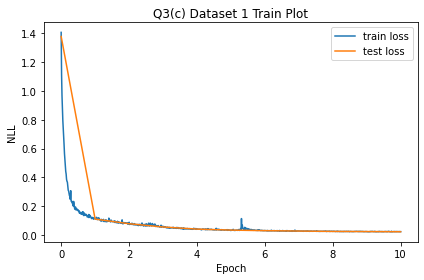

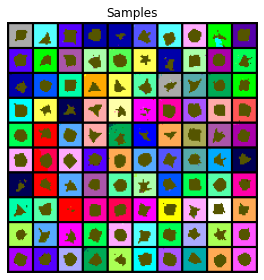

In [ ]:
q3bc_save_results(1, 'c', q3_c)

Epoch:  1  Test Loss:  0.07396096736192703
Epoch:  2  Test Loss:  0.04307529330253601
Epoch:  3  Test Loss:  0.03953838720917702
Epoch:  4  Test Loss:  0.03625549003481865
Epoch:  5  Test Loss:  0.03477812558412552
Epoch:  6  Test Loss:  0.03388398885726929
Epoch:  7  Test Loss:  0.037942077964544296
Epoch:  8  Test Loss:  0.03223244100809097
Epoch:  9  Test Loss:  0.03207651525735855
Epoch:  10  Test Loss:  0.03241189196705818
Final Test Loss: 0.0324


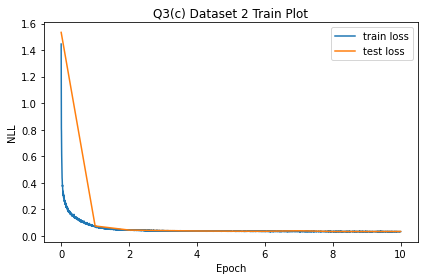

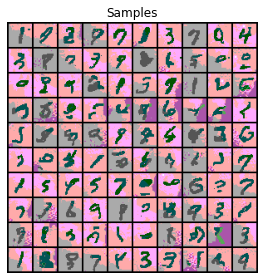

In [ ]:
q3bc_save_results(2, 'c', q3_c)

## Part (d) Conditional PixelCNNs

In this part, implement and train a **class-conditional** PixelCNN on binary MNIST. Condition on a class label by adding a conditional bias in each convolutional layer. More precisely, in the $\ell$th convolutional layer, compute: 
$$W_\ell * x + b_\ell + V_\ell y$$
where $W_\ell * x + b_\ell$ is a masked convolution (as in previous parts), $V$ is a 2D weight matrix, and $y$ is a one-hot encoding of the class label (where the conditional bias is broadcasted spacially and added channel-wise).

You can use a PixelCNN architecture similar to part (a). Training on the shapes dataset should be quick, and MNIST should take around 10-15 minutes


**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
class Binary_MaskedConvLayer(nn.Conv2d):
  def __init__(self, mask_type, n_classes, *args, **kwargs):
    super(Binary_MaskedConvLayer, self).__init__(*args, **kwargs)

    assert mask_type == 'A' or mask_type == 'B'
    self.mask_type = mask_type
    self.register_buffer('mask', torch.zeros_like(self.weight))
    self.create_mask()
    self.class_cond_weight = nn.Linear(in_features = n_classes, out_features = self.out_channels)

  
  def create_mask(self):
    k = self.kernel_size[0]

    # out_channels x in_channels x kernel_size x kernel_size
    self.mask[:, :, :k//2, :] = 1
    self.mask[:, :, k//2, :k//2] = 1

    if self.mask_type == 'B':
      self.mask[:, :, k//2, k//2] = 1


  def forward(self, x, y):
    conv_out = F.conv2d(input = x, weight = self.weight * self.mask, bias = self.bias, stride = self.stride, 
                   padding = self.padding, dilation = self.dilation, groups = self.groups) # batch_size x n_filters x inp_shape
    # y -> batch_size x n_classes (one-hot encoding)
    cond_out = self.class_cond_weight(y) # batch_size x out_channels
    cond_out = cond_out.unsqueeze(-1).unsqueeze(-1)
    out = torch.add(conv_out, cond_out)    
    return out

  
class Binary_PixelCNN(nn.Module):
  def __init__(self, n_classes, n_filters = 64):
    super(Binary_PixelCNN, self).__init__()

    self.n_filters = n_filters
    self.models = nn.ModuleList()
    self.models.append(Binary_MaskedConvLayer(mask_type = 'A', n_classes = n_classes, in_channels = 1, out_channels = n_filters, kernel_size = 7, padding = 7//2))
    self.models.append(nn.ReLU())
    

    # 5 7 x 7 B conv layers
    for _ in range(0, 5):
      self.models.append(Binary_MaskedConvLayer(mask_type = 'B', n_classes = n_classes, in_channels = n_filters, out_channels = n_filters, kernel_size = 7, padding = 7//2))
      self.models.append(nn.ReLU())
    
    # 2 1 x 1 B conv layers
    
    self.models.append(Binary_MaskedConvLayer(mask_type = 'B', n_classes = n_classes, in_channels = n_filters, out_channels = n_filters, kernel_size = 1, padding = 1//2))
    self.models.append(nn.ReLU())

    # output = 2 x inp_shape
    self.models.append(Binary_MaskedConvLayer(mask_type = 'B', n_classes = n_classes, in_channels = n_filters, out_channels = 2, kernel_size = 1, padding = 1//2))
    
    

  def forward(self, x, y):
    # x = x.float()
    x = (x.float() - 0.5) / 0.5
    batch_size = x.shape[0]
    y = y.float()
    out = x.clone()

    inp_shape = (x.shape[1], x.shape[2], x.shape[3]) # 1 x W x H

    for layer in self.models:
      if isinstance(layer, Binary_MaskedConvLayer):
        out = layer(out, y)
      else:
        out = layer(out)

    # out shape = 2 x inp_shape
    return out.contiguous().view(batch_size, 2, *inp_shape)

  def loss(self, x, y):
    out = self(x, y)
    return F.cross_entropy(out, x.long())
    

  def sample(self, N, inp_shape, n_classes):
    sample_imgs = torch.zeros(N, *inp_shape).cuda()
    H, W = inp_shape[1], inp_shape[2]

    samples_per_class = int(N/n_classes)
    labeled_y = torch.arange(start = 0, end = n_classes).cuda()
    labeled_y = labeled_y.unsqueeze(-1).repeat((1,samples_per_class)).view(n_classes*samples_per_class)
    y_ohe = F.one_hot(labeled_y)
        

    with torch.no_grad():
      for i in range(0, H):
        for j in range(0, W):
          out = self(sample_imgs, y_ohe)[:, :, 0, i, j] # shape -> N x 2 x 1 x 1 x 1

          softmax = nn.Softmax(dim = 1)
          probs = softmax(out) # shape -> N x 2 x 1 x 1 x 1
          sampled = torch.multinomial(input = probs, num_samples = 1)

          sample_imgs[:, 0, i, j] = sampled.squeeze(-1)

      return sample_imgs.permute(0, 2, 3, 1).cpu().numpy()





In [ ]:
def preprocess(data, labels, n_classes):
  data = np.transpose(data, (0, 3, 1, 2))
  labels_one_hot = np.zeros((len(labels), n_classes))
  labels_one_hot[np.arange(len(labels)),labels] = 1
  return data, labels_one_hot


class Data_Q3_d(data.Dataset):
  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    return self.x[index], self.y[index]

def train(model, data_loader, optimizer, device):
  # Returns list of train losses for each batch
  model.train()
  train_losses = []
  for d in data_loader:
    x, y = d
    x = x.to(device)
    y = y.to(device)

    loss = model.loss(x, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

  return train_losses

def eval_model(model, data_loader, device):
  model.eval()

  test_loss = 0.0

  with torch.no_grad():
    for d in data_loader:
      x, y = d
      x = x.to(device)
      y = y.to(device)

      loss = model.loss(x, y)

      test_loss = test_loss + loss*x.shape[0]
    test_loss = test_loss/len(data_loader.dataset)

  return test_loss.item()

    

def train_model(model, train_data_loader, test_data_loader, train_args):

  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")

  model = model.to(device)
  epochs = train_args.get('epochs', 10)
  lr = train_args.get('lr', 1e-3)

  optimizer = optim.Adam(params = model.parameters(), lr = lr)

  train_losses = []
  test_losses = [eval_model(model, test_data_loader, device)]

  for i in range(0, epochs):
    model.train()

    train_losses.extend(train(model = model, data_loader = train_data_loader, optimizer = optimizer,
                            device = device))
    test_loss_epoch = eval_model(model = model, data_loader = test_data_loader, device = device)
    test_losses.append(test_loss_epoch)

    print("Epoch: ",(i+1)," Test Loss: ",test_loss_epoch)

  return train_losses, test_losses




In [ ]:
def q3_d(train_data, train_labels, test_data, test_labels, image_shape, n_classes, dset_id):
  """
  train_data: A (n_train, H, W, 1) numpy array of binary images with values in {0, 1}
  train_labels: A (n_train,) numpy array of class labels
  test_data: A (n_test, H, W, 1) numpy array of binary images with values in {0, 1}
  test_labels: A (n_test,) numpy array of class labels
  image_shape: (H, W), height and width
  n_classes: number of classes (4 or 10)
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, C, 1) of samples with values in {0, 1}
    where an even number of images of each class are sampled with 100 total
  """
  
  """ YOUR CODE HERE """
  H, W = image_shape
  tr_data, tr_y_ohe = preprocess(train_data, train_labels, n_classes)
  ts_data, ts_y_ohe = preprocess(test_data, test_labels, n_classes)

  train_data_set = Data_Q3_d(tr_data, tr_y_ohe)
  test_data_set = Data_Q3_d(ts_data, ts_y_ohe)

  train_data_loader = data.DataLoader(dataset = train_data_set, batch_size = 128, shuffle = True)
  test_data_loader = data.DataLoader(dataset = test_data_set, batch_size = 128)

  model = Binary_PixelCNN(n_classes)

  train_args = {'epochs':10, 'lr':1e-3}
  train_losses, test_losses = train_model(model = model, train_data_loader = train_data_loader, 
                                          test_data_loader = test_data_loader, train_args = train_args)
  
  samples = model.sample(100, (1, *image_shape), n_classes)
  

  return train_losses, test_losses, samples




### Results

Once you've implemented `q3_d`, execute the cells below to visualize and save your results



Epoch:  1  Test Loss:  0.1107904389500618
Epoch:  2  Test Loss:  0.09372694045305252
Epoch:  3  Test Loss:  0.08003141731023788
Epoch:  4  Test Loss:  0.0687793642282486
Epoch:  5  Test Loss:  0.058510903269052505
Epoch:  6  Test Loss:  0.052136458456516266
Epoch:  7  Test Loss:  0.049045439809560776
Epoch:  8  Test Loss:  0.04638371244072914
Epoch:  9  Test Loss:  0.04394197836518288
Epoch:  10  Test Loss:  0.042297761887311935
Final Test Loss: 0.0423


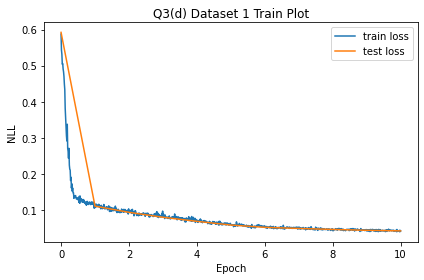

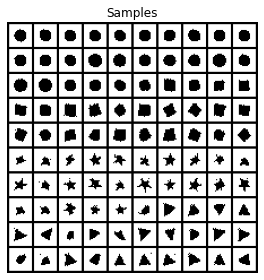

In [ ]:
q3d_save_results(1, q3_d)

Epoch:  1  Test Loss:  0.08517643064260483
Epoch:  2  Test Loss:  0.08042095601558685
Epoch:  3  Test Loss:  0.07824724167585373
Epoch:  4  Test Loss:  0.0771884098649025
Epoch:  5  Test Loss:  0.07558225840330124
Epoch:  6  Test Loss:  0.07489682734012604
Epoch:  7  Test Loss:  0.07456947863101959
Epoch:  8  Test Loss:  0.073658287525177
Epoch:  9  Test Loss:  0.07336679100990295
Epoch:  10  Test Loss:  0.07320886105298996
Final Test Loss: 0.0732


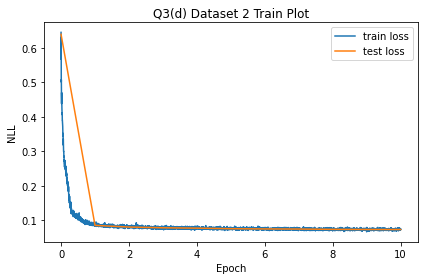

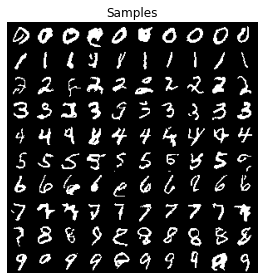

In [ ]:
q3d_save_results(2, q3_d)

# Question 4: Bonus Questions (Optional)

## Part (a) Gated PixelCNN
Implement a [Gated PixelCNN](https://arxiv.org/abs/1606.05328) to fix the blind-spot issue, and report training curves, final test loss, and samples.

In [ ]:
class Color_MaskedConvLayer(nn.Conv2d):
  def __init__(self, mask_type, color_cond = 0, *args, **kwargs):
    super(Color_MaskedConvLayer, self).__init__(*args, **kwargs)

    assert mask_type == 'A' or mask_type == 'B'
    self.mask_type = mask_type
    self.register_buffer('mask', torch.zeros_like(self.weight))
    self.color_cond = color_cond
    self.create_mask()
  
  def create_mask(self):
    k = self.kernel_size[0]

    # out_channels x in_channels x kernel_size x kernel_size
    self.mask[:, :, :k//2, :] = 1
    self.mask[:, :, k//2, :k//2] = 1

    if self.color_cond:
      assert self.out_channels % 3 == 0 and self.in_channels % 3 == 0
      one_third_out = int(self.out_channels/3)
      one_third_in = int(self.in_channels/3)
      if self.mask_type == 'A':
        # self.mask[:one_third_out, ]
        self.mask[one_third_out:2*one_third_out, :one_third_in, k//2, k//2] = 1
        self.mask[2*one_third_out: , :2*one_third_in, k//2, k//2] = 1
      else:
        self.mask[:one_third_out, :one_third_in, k//2, k//2] = 1
        self.mask[one_third_out:2*one_third_out, :2*one_third_in, k//2, k//2] = 1
        self.mask[2*one_third_out:, :, k//2, k//2] = 1

    elif self.mask_type == 'B':
      self.mask[:, :, k//2, k//2] = 1


  def forward(self, x):
    out = F.conv2d(input = x, weight = self.weight * self.mask, bias = self.bias, stride = self.stride, 
                   padding = self.padding, dilation = self.dilation, groups = self.groups)
    return out

class GatedConvLayer(nn.Module):
  def __init__(self, mask_type, in_channels, kernel_size):
    super(GatedConvLayer, self).__init__()

    self.vertical_stack = nn.Conv2d(in_channels = in_channels, out_channels = 2*in_channels, kernel_size = kernel_size, padding = kernel_size//2)
    self.horizontal_stack = nn.Conv2d(in_channels = in_channels, out_channels = 2*in_channels, kernel_size = (1, kernel_size), padding = (0, kernel_size//2))

    self.register_buffer('vs_mask', torch.zeros_like(self.vertical_stack.weight))
    self.register_buffer('hs_mask', torch.zeros_like(self.horizontal_stack.weight))

    self.vs_mask[:, :, :kernel_size//2 + 1, :] = 1
    self.hs_mask[:, :, :, :kernel_size//2 + 1] = 1

    if mask_type == 'A':
      self.hs_mask[:, :, :, kernel_size//2] = 0

    self.vtoh = nn.Conv2d(in_channels = 2*in_channels, out_channels = 2*in_channels, kernel_size = 1)
    self.htoh = nn.Conv2d(in_channels = in_channels, out_channels = in_channels, kernel_size = 1)


  def downshift(self, x):
    zero_pad = nn.ZeroPad2d((0, 0, 1, 0))
    return zero_pad(x[:, :, :-1, :])

  def forward(self, x):
    # Split the input into 2 parts (by channels) - one goes into the vertical stack, the other into the horizontal stack
    v_x, h_x = torch.chunk(x, 2, dim = 1)
    

    # Mask out the conv weights
    self.vertical_stack.weight.data = self.vertical_stack.weight.data*self.vs_mask
    self.horizontal_stack.weight.data = self.horizontal_stack.weight.data*self.hs_mask

    v_out = self.vertical_stack(v_x)
    h_out = self.horizontal_stack(h_x)

    # let's finish the lhs piece first!
    
    # v_out is chunked into 2 parts and fed into the gated layers
    v_out_t, v_out_s = torch.chunk(v_out, 2, dim = 1)
    lhs_out = torch.tanh(v_out_t)*torch.sigmoid(v_out_s)

    # Now to the rhs piece!

    # feed v_out into the 1x1 conv layer so that the horizontal stack can see it!
    h_out = h_out + self.vtoh(self.downshift(v_out))

    # Now chunk it and feed it into the gated layers
    h_out_t, h_out_s = torch.chunk(h_out, 2, dim = 1)
    rhs_out = torch.tanh(h_out_t)*torch.sigmoid(h_out_s)

    # now into the final 1x1 layer
    rhs_out = self.htoh(rhs_out)
    rhs_out = rhs_out + h_x

    # finally concat lhs_out & rhs_out
    return torch.cat((lhs_out, rhs_out), dim = 1)


class GatedPixelCNN(nn.Module):
  def __init__(self, n_colors, n_layers = 5, n_filters = 64, kernel_size = 7):
    super(GatedPixelCNN, self).__init__()
    self.n_colors = n_colors

    self.models = []
    self.conv_in = Color_MaskedConvLayer(mask_type = 'A', in_channels = 3, out_channels = n_filters, kernel_size = kernel_size, padding = kernel_size//2)
    
    for _ in range(0, n_layers):
      # self.models.append(nn.BatchNorm2d(num_features = n_filters))
      self.models.append(nn.ReLU())
      self.models.append(GatedConvLayer(mask_type = 'B', in_channels = n_filters, kernel_size = kernel_size))

    self.models.append(nn.ReLU())
    self.conv_out = Color_MaskedConvLayer(mask_type = 'B', in_channels = n_filters, out_channels = n_colors*3, kernel_size = kernel_size, padding = kernel_size//2)

    self.net = nn.Sequential(*self.models)

  def forward(self, x):
    batch_size = x.shape[0]
    out = (x.float()/(self.n_colors - 1) - 0.5)/0.5
    out = self.conv_in(out)
    
    out = torch.cat((out, out), dim = 1)
    # print(out.shape)
    
    out = self.net(out)
    out = self.conv_out(torch.chunk(out, 2, dim=1)[1])
    # out = self.conv_out(out)

    return out.contiguous().view(batch_size, 3, self.n_colors, x.shape[2], x.shape[3]).permute(0, 2, 1, 3, 4)

  
  def loss(self, x):
    out = self(x)
    return F.cross_entropy(input = out, target = x.long())



  def sample(self, N, inp_shape):
    sample_imgs = torch.zeros(N, *inp_shape).cuda()
    C, H, W = inp_shape[0], inp_shape[1], inp_shape[2]

    with torch.no_grad():
      for i in range(0, H):
        for j in range(0, W):
          for k in range(0, 3):
            out = self(sample_imgs)[:, :, k, i, j] # shape -> N x 4 x 1 x 1 x 1

            softmax = nn.Softmax(dim = 1)
            probs = softmax(out) # shape -> N x 4 x 1 x 1 x 1
            sampled = torch.multinomial(input = probs, num_samples = 1)

            sample_imgs[:, k, i, j] = sampled.squeeze(-1)

      return sample_imgs.permute(0, 2, 3, 1).cpu().numpy()







### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q4_a(train_data, test_data, image_shape):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of generated samples with values in {0, 1, 2, 3}
  """
  """ YOUR CODE HERE """

  H, W, C = image_shape
  
  train_data = np.transpose(train_data, (0, 3, 1, 2))
  test_data = np.transpose(test_data, (0, 3, 1, 2))

  train_data_loader = data.DataLoader(dataset = train_data, batch_size = 128, shuffle = True)
  test_data_loader = data.DataLoader(dataset = test_data, batch_size = 128)

  model = GatedPixelCNN(n_colors = 4)

  train_args = {'epochs':15, 'lr':1e-3}
  train_losses, test_losses = train_model(model = model, train_data_loader = train_data_loader, 
                                          test_data_loader = test_data_loader, train_args = train_args)


  samples = model.sample(100, (C, H, W))

  return train_losses, test_losses, samples

### Results

Once you've implemented `q4_a`, execute the cells below to visualize and save your results



In [ ]:
q4a_save_results(q4_a)

Using device ...  cuda
Epoch:  1  Test Loss:  0.21885627508163452
Epoch:  2  Test Loss:  0.17428581416606903
Epoch:  3  Test Loss:  0.12850424647331238
Epoch:  4  Test Loss:  0.10314463824033737
Epoch:  5  Test Loss:  0.09484721720218658
Epoch:  6  Test Loss:  0.09285176545381546
Epoch:  7  Test Loss:  0.08746267855167389
Epoch:  8  Test Loss:  0.08585131168365479
Epoch:  9  Test Loss:  0.08498889207839966


## Part (b) Grayscale PixelcNN
Train a [Grayscale PixelCNN](https://arxiv.org/abs/1612.08185) on Colored MNIST. You do not need to use their architecture - stacking standard masked convolutions or residual blocks is fine. First, generate a binary image, and then the 2-bit color image.

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q4_b(train_data, test_data, image_shape):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (50, H, W, 1) of generated binary images in {0, 1}
  - a numpy array of size (50, H, W, C) of conditonally generated color images in {0, 1, 2, 3}
  """
  # You will need to generate the binary image dataset from train_data and test_data
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q4_b`, execute the cells below to visualize and save your results



In [ ]:
q4b_save_results(q4_b)

## Part (c) Parallel Multiscale PixelCNN
One large disadvantage of autoregressive models is their slow sampling speed, since they require one network evaluation per feature. However, there are existing methods which introduce different independence assumptions to allow for parallelism when sampling. Implement a [Parallel PixelCNN](https://arxiv.org/abs/1703.03664) on 56 x 56 MNIST images, with a base size of 7 x 7 and upscaling by a factor of 2. Sampling should be very quick (< 1s). Architectures may vary, but using small PixelCNN implementation similar to previous parts and small ResNets should suffice

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q4_c(train_data, test_data):
  """
  train_data: A (60000, 56, 56, 1) numpy array of grayscale images with values in {0, 1}
  test_data: A (10000, 56, 56, 1) numpy array of grayscale images with values in {0, 1}
  image_shape: (H, W), height and width

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, 56, 56, 1) of generated samples with values in {0, 1}
  """
 
  """ YOUR CODE HERE """

### Results

Once you've implemented `q4_c`, execute the cells below to visualize and save your results



In [ ]:
q4c_save_results(q4_c)